# TM10007 Assignment: 
Janna Meijer, Jasmijn Visser, Lotte Kuiper

## Data loading and cleaning
Input = raw data
Output = X_drop & Y_drop

In [130]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import percentile
from worcliver.load_data import load_data
from sklearn import linear_model, preprocessing, svm, datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, KFold, learning_curve
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.pipeline import Pipeline
from scipy.stats import normaltest
from sklearn.decomposition import PCA
import statistics
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [131]:
data = load_data()

# De label kolom even uit de dataset halen
X = data.drop('label', axis=1)   # drop the label category
y = data['label']                # Target variable die we proberen te voorspellen met het algoritme

# Make a list of feature names
feature_names = list(X.columns)

n_samples = len(data.index)
n_features = len(X.columns)
print(f'The number of samples: {n_samples}')
print(f'The number of features: {n_features}')

n_malignant = len(y[y=='malignant'])
n_benign = len(y[y=='benign'])
print(f'The number of malignant samples: {n_malignant}')
print(f"The number of benign samples: {n_benign}")

The number of samples: 186
The number of features: 493
The number of malignant samples: 94
The number of benign samples: 92


### Deleting incomplete features and patients

In [132]:
nullen = X.eq(0.0).sum()
alle_nullen = sum(nullen)
print(f'Aantal nullen in de data: {alle_nullen}') 

patient0={}
for patients in X.index:
    zero_count1 = (X.loc[patients]==0.0).sum()
    patient0[patients]=zero_count1

#print(f"Hoeveelheid nullen per patient: {patient0}")

features0={}
for features in X.columns:
    zero_count2 = (X[features]==0).sum()
    features0[features]=zero_count2

features0 = {feature: count for feature, count in features0.items() if count!=0} #om alle volledige rijen, met 0 zeros eruit te halen. Vooral voor overzicht voor onszelf. 

#print(f"Hoeveelheid nullen per feature: {features0}")

cutoff_feature = 0.7*n_samples
#cutoff_sample = 0.9*n_features

X_drop = X[:]
Y_drop = y[:]

for feature, counts in features0.items():
    if counts >= cutoff_feature:
        X_drop = X_drop.drop(feature, axis=1)

# for patient, count in patient0.items():
#     if count >= cutoff_sample:
#         X_drop = X_drop.drop(patient, axis=0)
#         Y_drop = Y_drop.drop(patient, axis=0)
            
print(f"Dimensies dataframe na verwijderen unrelevant features {X_drop.shape}")

Aantal nullen in de data: 4341
Dimensies dataframe na verwijderen unrelevant features (186, 469)


## Algemene stappen
Input = X_drop & Y_drop
Output = X_test_normalised, X_train_normalized, Y_train & Y_test

### Splitting data into test and trainingset

In [133]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_drop, Y_drop, test_size=0.2, random_state=42)

print("Training set dimensies:", X_train.shape, y_train.shape)
print("Testing set dimensies:", X_test.shape, y_test.shape)


Training set dimensies: (148, 469) (148,)
Testing set dimensies: (38, 469) (38,)


### Outliers


In [134]:
k = 1.5
n_outliers={}

#print(X_train.head)

X_train_out = X_train[:]
X_test_out = X_test[:]

for feature in X_train_out.columns:
    q25, q75 = percentile(X_train_out[feature], 25), percentile(X_train_out[feature], 75)
    iqr = q75 - q25
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in X_train_out[feature] if x < lower or x > upper]
    n_outliers[feature] = len(outliers)

    if any(X_train_out[feature] < lower):
        X_train_out.loc[X_train_out[feature] < lower, feature] = lower
    if any(X_train_out[feature] > upper):
        X_train_out.loc[X_train_out[feature] > upper, feature] = upper    

    if any(X_test_out[feature] < lower):
        X_test_out.loc[X_test_out[feature] < lower, feature] = lower
    if any(X_test_out[feature] > upper):
        X_test_out.loc[X_test_out[feature] > upper, feature] = upper

print(n_outliers)
print(sum(n_outliers.values()))
print(max(n_outliers.values()))

#print(X_train_out.head)

            

{'PREDICT_original_sf_compactness_avg_2.5D': 8, 'PREDICT_original_sf_compactness_std_2.5D': 15, 'PREDICT_original_sf_rad_dist_avg_2.5D': 3, 'PREDICT_original_sf_rad_dist_std_2.5D': 5, 'PREDICT_original_sf_roughness_avg_2.5D': 2, 'PREDICT_original_sf_roughness_std_2.5D': 10, 'PREDICT_original_sf_convexity_avg_2.5D': 8, 'PREDICT_original_sf_convexity_std_2.5D': 19, 'PREDICT_original_sf_cvar_avg_2.5D': 8, 'PREDICT_original_sf_cvar_std_2.5D': 13, 'PREDICT_original_sf_prax_avg_2.5D': 0, 'PREDICT_original_sf_prax_std_2.5D': 1, 'PREDICT_original_sf_evar_avg_2.5D': 2, 'PREDICT_original_sf_evar_std_2.5D': 8, 'PREDICT_original_sf_solidity_avg_2.5D': 11, 'PREDICT_original_sf_solidity_std_2.5D': 18, 'PREDICT_original_sf_area_avg_2.5D': 14, 'PREDICT_original_sf_area_max_2.5D': 12, 'PREDICT_original_sf_area_min_2.5D': 9, 'PREDICT_original_sf_area_std_2.5D': 13, 'PREDICT_original_sf_volume_2.5D': 12, 'PREDICT_original_of_theta_x': 0, 'PREDICT_original_of_theta_y': 7, 'PREDICT_original_of_theta_z': 0,

### Scaling the data

C:\Users\lotte\AppData\Local\Temp\ipykernel_2752\3036259404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_norm['label'] = y_train.values    #alleen voor het plotten


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen')]

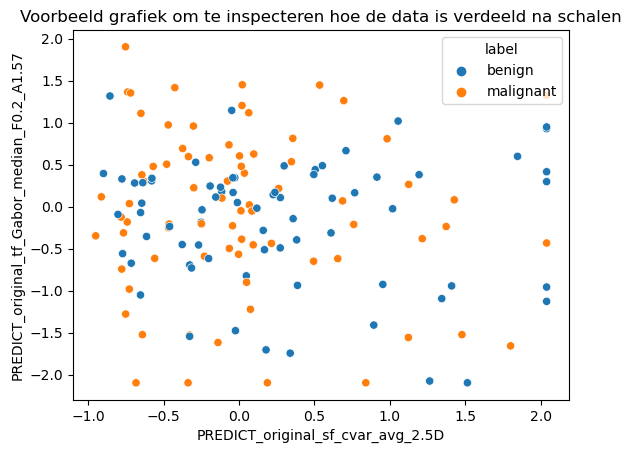

In [135]:
scaler = RobustScaler().fit(X_train_out) #Dit schaalt de data
X_train_normalized = scaler.transform(X_train_out)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 

X_test_normalized = scaler.transform(X_test_out)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Plotten om te zien hoe het er nu uitziet: 
X_train_norm = X_train_normalized[:]     #alleen voor het plotten
X_train_norm['label'] = y_train.values    #alleen voor het plotten
sb.scatterplot(data=X_train_norm, x=feature_names[8], y=feature_names[340], hue='label').set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen")



## Finding hyperparameters for Lasso & PCA
Input = X_train_normalized, Y_train
Output = C & n_components

### Find new hyperparameters

In [136]:
# Pipeline: schaling is al gebeurd, KNN staat vast (default), Lasso & PCA variëren

pipe_KNN = Pipeline([('lasso', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
                    ('pca', PCA()),
                    ('classifier', KNeighborsClassifier())])

parameters = {'lasso__estimator__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5], 
              'pca__n_components': [0.7,0.75,0.8,0.85,0.9,0.95,0.99],
              }

search_fs = RandomizedSearchCV(pipe_KNN, parameters, cv=5, n_iter=98, return_train_score=True, scoring="roc_auc")
search_fs.fit(X_train_normalized, y_train)
print("Best hyperparameters: ", search_fs.best_params_)
print('validation set score: ' + str(search_fs.best_score_))

best_index = search_fs.best_index_ 
train_score = search_fs.cv_results_[f"mean_train_score"][best_index]           
validation_score = search_fs.cv_results_[f"mean_test_score"][best_index]   #ging even checken of hieruit hetzelfde kwam als best_score_ en dat klopt

print("train score: ", train_score)
print("validation score: ", validation_score)

Best hyperparameters:  {'pca__n_components': 0.85, 'lasso__estimator__C': 0.5}
validation set score: 0.8106884920634922
train score:  0.9343058324159749
validation score:  0.8106884920634922


### Find new shape after applying optimized parameters for PCA and LASSO

In [137]:

C = search_fs.best_params_['lasso__estimator__C'] 
n_components = search_fs.best_params_['pca__n_components']

logistic = LogisticRegression(C=C, penalty='l1', solver='liblinear', random_state=7)

model = SelectFromModel(logistic)
model.fit(X_train_normalized,y_train)
#X_train_selected = model.transform(X_train_normalized)

SF = model.get_support()
X_train_features = X_train_normalized.loc[:,SF]

print(X_train_features.shape)

pca=PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)

print(pca.n_components_)
print(X_train_pca.shape)


(148, 48)
19
(148, 19)


## Choosing a classifier and hyperparameters
Input = C, n_components, X_train_normalized, Y_train
Output = train & validation score per classifier + best parameters for the classifier

### Test different classifiers

In [138]:
# Feature selection

C = search_fs.best_params_['lasso__estimator__C'] 
n_components = search_fs.best_params_['pca__n_components']

lasso_pca = [('lasso', SelectFromModel(LogisticRegression(C=C, penalty='l1', solver='liblinear'))),
             ('pca', PCA(n_components=n_components))]

# Testing different classifiers

pipe_knn = Pipeline(lasso_pca + [('classifier', KNeighborsClassifier())])
pipe_rf = Pipeline(lasso_pca + [('classifier', RandomForestClassifier())])
pipe_svc = Pipeline(lasso_pca + [('classifier', svm.SVC())])

parameters_knn = {'classifier__n_neighbors': range(5,30),
                  'classifier__p': [1, 2],
                  'classifier__leaf_size': [1, 5, 10, 15]
                 }

parameters_rf = {'classifier__n_estimators': [10, 50, 100, 150, 200],
                 'classifier__max_depth': [3, 4, 5, 6, 7],
                 'classifier__min_samples_split': [2, 4, 8, 10, 15, 20],
                 'classifier__max_features': ['sqrt','log2', None]
                }

parameters_svc = {'classifier__kernel': ['linear', 'rbf', 'poly'],
                  'classifier__C': [0.01, 0.1, 1, 10],
                  'classifier__gamma': [0.001, 0.001, 0.01, 0.1, 1],
                  'classifier__degree': [1, 2, 3, 4, 5, 6, 7]
                 }

classifiers = {'knn': (pipe_knn, parameters_knn),
               'Random Forest': (pipe_rf, parameters_rf),
               'SVC': (pipe_svc, parameters_svc)}

best_params_dict = {}
for name, (classifier, parameter) in classifiers.items():
    best_params_dict[name] = {"params": [], "val_scores": [], "train_scores": []}
    search = RandomizedSearchCV(classifier, parameter, cv=5, n_iter=50, return_train_score=True, scoring="roc_auc")
    search.fit(X_train_normalized, y_train)
    best_params_dict[name]["params"].append(search.best_params_)
    best_index = search.best_index_
    best_val_score = search.best_score_
    best_train_score = search.cv_results_[f"mean_train_score"][best_index]
    best_params_dict[name]["val_scores"].append(best_val_score)
    best_params_dict[name]["train_scores"].append(best_train_score)

print(best_params_dict)


### Comparison ROC curves different classifiers

In [ ]:
y_test_int = pd.Series(y_test).map({'malignant': 1, 'benign': 0}).astype(int)

#SVC on ROC curve
C = 1
kernel = 'linear'

lasso_C = 0.5
pca_n = 0.85

lasso_pca = [('lasso', SelectFromModel(LogisticRegression(C=lasso_C, penalty='l1', solver='liblinear'))),
             ('pca', PCA(n_components=pca_n))]

model_svc = Pipeline(lasso_pca + [('classifier', svm.SVC(C=C, kernel=kernel, probability=True))])
model_svc.fit(X_train_normalized, y_train)

y_pred_proba_svc = model_svc.predict_proba(X_test_normalized)[:, 1]

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test_int, y_pred_proba_svc)
auc_score_svc = roc_auc_score(y_test_int, y_pred_proba_svc)

# KNN on ROC curve
best_params_knn = best_params_dict['knn']['params'][0]
n_neighbors = best_params_knn['classifier__n_neighbors']
p = best_params_knn['classifier__p']

model_knn = Pipeline(lasso_pca + [('classifier', KNeighborsClassifier(n_neighbors=n_neighbors, p=p))])
model_knn.fit(X_train_normalized, y_train)

y_pred_proba_knn = model_knn.predict_proba(X_test_normalized)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_int, y_pred_proba_knn)
auc_score_knn = roc_auc_score(y_test_int, y_pred_proba_knn)

# RF on ROC curve
best_params_rf = best_params_dict['Random Forest']['params'][0]
n_estimators = best_params_rf['classifier__n_estimators']
max_depth = best_params_rf['classifier__max_depth']
min_samples_split = best_params_rf['classifier__min_samples_split']
max_features = best_params_rf['classifier__max_features']

model_rf = Pipeline(lasso_pca + [('classifier', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, max_features=max_features))])
model_rf.fit(X_train_normalized, y_train)

y_pred_proba_rf = model_rf.predict_proba(X_test_normalized)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_int, y_pred_proba_rf)
auc_score_rf = roc_auc_score(y_test_int, y_pred_proba_rf)

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {auc_score_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {auc_score_rf:.2f})')
plt.plot(fpr_svc, tpr_svc, color='red', lw=2, label=f'SVC (AUC = {auc_score_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


## Full method

### Define the full method

In [ ]:
# Defining our FULL model
lasso_C = 0.5
pca_n = 0.85
lasso_pca = [('lasso', SelectFromModel(LogisticRegression(C=lasso_C, penalty='l1', solver='liblinear'))),
             ('pca', PCA(n_components=pca_n))]
classifier_chosen = Pipeline(lasso_pca + [('classifier', svm.SVC(kernel='linear', C=1, probability=True))])
classifier_chosen.fit(X_train_normalized,y_train)

# Predicting test set labels
y_pred = classifier_chosen.predict(X_test_normalized)
le = LabelEncoder()
le.fit(['benign', 'malignant'])
y_test_bin = le.transform(y_test)
y_pred_bin = le.transform(y_pred)

# Calculating results
y_proba = classifier_chosen.predict_proba(X_test_normalized)[:, 1]
auc_score_test = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test_bin, y_pred_bin).ravel()
sensitivity = recall_score(y_test_bin, y_pred_bin)
specificity = tn / (tn + fp)

print(f'Accuracy:{accuracy}')
print(f'AUC:{auc_score_test}')
print(f'sensitivity:{sensitivity}')
print(f'specificity:{specificity}')

### Learning curve

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    classifier_chosen, X_train_normalized, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning curve SVC classifier of train set')
plt.legend()
plt.show()

## Evaluation of method with testset

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)        
cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)


n_outliers={}
k=1.5
history = []
pointer = 1

Y_drop = np.ravel(Y_drop) #om Y_drop dezelfde type te krijgen als X_drop. anders doet de forloop het niet. 

for train_index, test_index in cv_outer.split(X_drop, Y_drop):
    x_train, x_test = X_drop.iloc[train_index], X_drop.iloc[test_index]
    y_train, y_test = Y_drop[train_index], Y_drop[test_index]
    print('\nNestedCV: {} of outer fold {}'.format(pointer, cv_outer.get_n_splits()))
    #Outliers
    X_train_out = x_train[:]
    X_test_out = x_test[:]
    for feature in X_train_out.columns:
        q25, q75 = percentile(X_train_out[feature], 25), percentile(X_train_out[feature], 75)
        iqr = q75 - q25
        cut_off = iqr * k
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = [x for x in X_train_out[feature] if x < lower or x > upper]
        n_outliers[feature] = len(outliers)

        if any(X_train_out[feature] < lower):
            X_train_out.loc[X_train_out[feature] < lower, feature] = lower
        if any(X_train_out[feature] > upper):
            X_train_out.loc[X_train_out[feature] > upper, feature] = upper    

        if any(X_test_out[feature] < lower):
            X_test_out.loc[X_test_out[feature] < lower, feature] = lower
        if any(X_test_out[feature] > upper):
            X_test_out.loc[X_test_out[feature] > upper, feature] = upper

    #Schalen
    scaler = RobustScaler().fit(X_train_out) #Dit schaalt de data
    X_train_normalized = scaler.transform(X_train_out)
    X_train_normalized = pd.DataFrame(X_train_normalized, columns=x_train.columns, index=x_train.index) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 

    X_test_normalized = scaler.transform(X_test_out)
    X_test_normalized = pd.DataFrame(X_test_normalized, columns=x_test.columns)

    #
    classifier_chosen.fit(X_train_normalized, y_train)
    pred_train = classifier_chosen.predict_proba(X_train_normalized)[:, 1]
    pred_test = classifier_chosen.predict_proba(X_test_normalized)[:, 1]
    auc_score_train = roc_auc_score(y_train, pred_train)
    auc_score_test = roc_auc_score(y_test, pred_test)
    print("""
    Best accuracy         : {:.2f}

    Training
        AUC: {:.3f}
    Test
        AUC: {:.3f}
         """.format(
        classifier_chosen.best_score_,
        auc_score_train,
        auc_score_test,
        )
    )
    history.append(auc_score_test)
    pointer += 1

print('Overall test performance: {:.2f}'.format(np.mean(history)))